In [104]:

### Import necessary dependencies
import numpy as np
import pandas as pd
import calendar
import datetime
from dateutil.relativedelta import relativedelta
import category_encoders as ce
import lightgbm
import itertools

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge,Lasso,LassoLarsCV
from  scipy.stats import zscore
import plotly.express as px
import plotly.offline as pyoff
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from random import random
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [176]:
# RMSE FUNCTION
def RMSE(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test, y_pred))
'''
The RMSE takes the error (the difference between your predictions 
and the actual values) and squares them. Then, it averages them out and 
calculates the square root of that mean. This double transformation has 
two effects: it gives more weight to the bigger errors and it stops positive 
and negative errors from cancelling out, since they will all become positive. 
It can be used to compare different forecasts for the same series but it is 
not very intuitive, so I wouldn’t use it on presentations for management.
'''
#MAE FUNCTION
def MAE(y_test,y_pred):
    return mean_absolute_error(y_test, y_pred)

'''
Also known as the Mean Absolute Deviation (MAD), the MAE sums the error in 
absolute value, so the negative differences won’t cancel out the positive
differences and averages them out. It is pretty intuitive, so it’s easy to
explain. One of its downsides is that it is scale-dependent, meaning that 
it will change depending on whether you are forecasting revenue in US Dollars
or in Euros, for example. Again, not very intuitive, but it will be useful
for calculating another error metric that we’ll see further down.
'''

#MAPE FUNCTION
def MAPE(y_test, y_pred): 
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# MASE FUNCTION
def MASE(training_df, y_test, y_pred):
    """
    Computes the MEAN-ABSOLUTE SCALED ERROR forcast error for univariate time series prediction.
    
    See "Another look at measures of forecast accuracy", Rob J Hyndman
    
    parameters:
        training_series: the series used to train the model, 1d numpy array
        testing_series: the test series to predict, 1d numpy array or float
        prediction_series: the prediction of testing_series, 1d numpy array (same size as testing_series) or float
        absolute: "squares" to use sum of squares and root the result, "absolute" to use absolute values.
    
    """
#     print("Needs to be tested.")
    n = training_df.shape[0]
    d = np.abs(  np.diff( training_df) ).sum()/(n-1)
    
    errors = np.abs(y_test - y_pred )
    return errors.mean()/d

In [13]:
BASE_PATH = 'data/'
annual_cases = pd.read_csv(BASE_PATH + 'contraceptive_case_data_annual.csv')
train = pd.read_csv(BASE_PATH + 'Train.csv')
product = pd.read_csv(BASE_PATH + 'product.csv')
monthly_cases = pd.read_csv(BASE_PATH + 'monthly_cases.csv')
site_df = pd.read_csv(BASE_PATH + 'service_delivery_site_data.csv')
ss = pd.read_csv(BASE_PATH + 'SampleSubmission.csv')

### merge product file and service_delivery_site_data file with contraceptive_logistics_data
train=train.merge(site_df[['site_code','site_type','site_latitude','site_longitude']],on='site_code')
train=train.merge(product[['product_code','product_type']],on='product_code')

### Create two columns ID and calendar. ID and calendar will be used later in the creation of the training data and the test data
train['ID']=train.year.astype(str)+' X '+train.month.astype(str)+' X '+train['site_code']+' X '+train['product_code']
train['calendar']=train[['year','month']].apply(lambda x:datetime.datetime(x['year'],x['month'],calendar.monthrange(x['year'],x['month'])[1]),axis=1)

In [63]:
use_df = train.groupby(['calendar'])['stock_distributed'].sum().reset_index()
use_df.set_index('calendar', inplace = True, drop = False)
train_df = use_df.iloc[:34, :]
test_df = use_df.iloc[34:, :]


In [64]:
stock_month = train.groupby(['year','month']).stock_distributed.sum().reset_index()
use_df.head()

,calendar,stock_distributed
calendar,,
2016-01-31,2016-01-31,6852
2016-02-29,2016-02-29,6111
2016-03-31,2016-03-31,9495
2016-04-30,2016-04-30,7664
2016-05-31,2016-05-31,9081


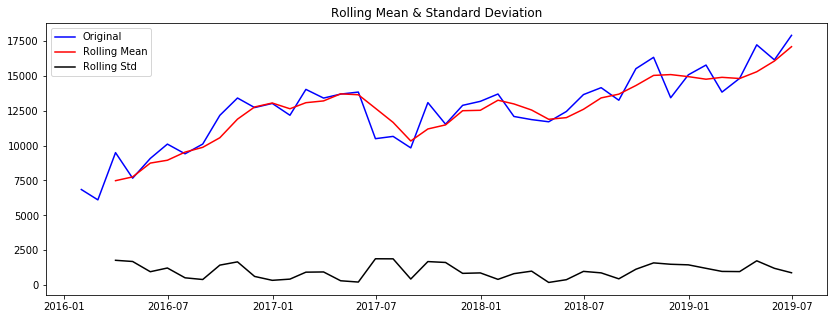

<Results of Dickey-Fuller Test>
Test Statistic                 -2.019886
p-value                         0.277922
#Lags Used                      1.000000
Number of Observations Used    40.000000
Critical Value (1%)            -3.605565
Critical Value (5%)            -2.937069
Critical Value (10%)           -2.606986
dtype: float64


In [65]:
from statsmodels.tsa.stattools import adfuller
df1=use_df.copy()

def test_stationarity(timeseries, dates):
    rolmean = timeseries.rolling(window=3).mean()
    rolstd = timeseries.rolling(window=3).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(dates, timeseries, color='blue',label='Original')
    mean = plt.plot(dates, rolmean, color='red', label='Rolling Mean')
    std = plt.plot(dates, rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(df1.stock_distributed.dropna(), df1.calendar)


In [270]:
import statsmodels.api as sm
fit1 = sm.tsa.statespace.SARIMAX(train_df.stock_distributed, order=(7, 1, 2), seasonal_order=(0, 1, 2, 7)).fit(use_boxcox=True)
test_df['SARIMA'] = fit1.predict(start=test_df['calendar'].min(), end="2019-11-01", dynamic=True)
plt.figure(figsize=(16, 8))
plt.plot(train_df['stock_distributed'], label='Train')
plt.plot(test_df['stock_distributed'], label='Test')
plt.plot(test_df['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()

ValueError: view limit minimum -36849.9 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

,calendar,stock_distributed
34,2018-11-30,13429
35,2018-12-31,15073
36,2019-01-31,15773
37,2019-02-28,13834
38,2019-03-31,14821
39,2019-04-30,17223
40,2019-05-31,16145
41,2019-06-30,17902


In [179]:
print('RMSE:', round(RMSE(test_df['stock_distributed'], test_df['SARIMA']), 2) )
print('MAE:', round(MAE(test_df['stock_distributed'], test_df['SARIMA']), 2))
print('MAPE:', round(MAPE(test_df['stock_distributed'], test_df['SARIMA']), 2))
print('MASE:', round(MASE(train_df['stock_distributed'], test_df['stock_distributed'], test_df['SARIMA']), 2))

RMSE: 2896.69
MAE: 2665.12
MAPE: 17.87
MASE: 2.34


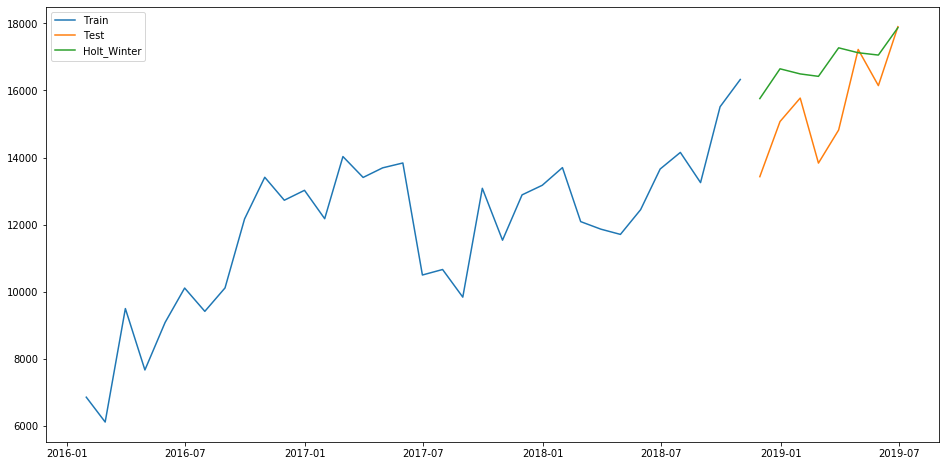

In [98]:
from statsmodels.tsa.api import ExponentialSmoothing
fit2 = ExponentialSmoothing(np.asarray(train_df['stock_distributed']) ,seasonal_periods=3 ,trend='add', seasonal='add').fit(use_boxcox=True)
test_df['Holt_Winter'] = fit2.forecast(len(test_df))
plt.figure(figsize=(16,8))
plt.plot(train_df['stock_distributed'], label='Train')
plt.plot(test_df['stock_distributed'], label='Test')
plt.plot(test_df['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [178]:
print('RMSE:', round(RMSE(test_df['stock_distributed'], test_df['Holt_Winter']), 2) )
print('MAE:', round(MAE(test_df['stock_distributed'], test_df['Holt_Winter']), 2))
print('MAPE:', round(MAPE(test_df['stock_distributed'], test_df['Holt_Winter']), 2))
print('MASE:', round(MASE(train_df['stock_distributed'], test_df['stock_distributed'], test_df['Holt_Winter']), 2))

RMSE: 1656.5
MAE: 1337.11
MAPE: 9.24
MASE: 1.18


In [106]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [123]:
y = use_df['stock_distributed']
min_aic = 1000
for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
        results = mod.fit()
        
        if results.aic < min_aic:
            min_aic = results.aic
            param_use, param_seasonal_use = param, param_seasonal
print('ARIMA{}x{}12 - AIC:{}'.format(param_use, param_seasonal_use, min_aic))


ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:263.93105436073404


In [125]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=param_use,
                                seasonal_order=param_seasonal_use,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8409      0.139     -6.044      0.000      -1.114      -0.568
ma.S.L12      -1.0203      1.855     -0.550      0.582      -4.656       2.616
sigma2      1.375e+06   2.64e+06      0.521      0.603    -3.8e+06    6.55e+06


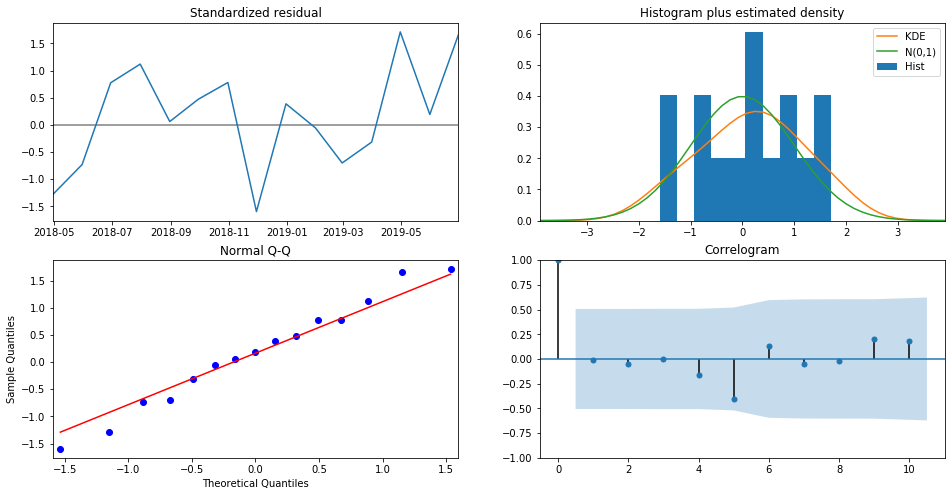

In [126]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

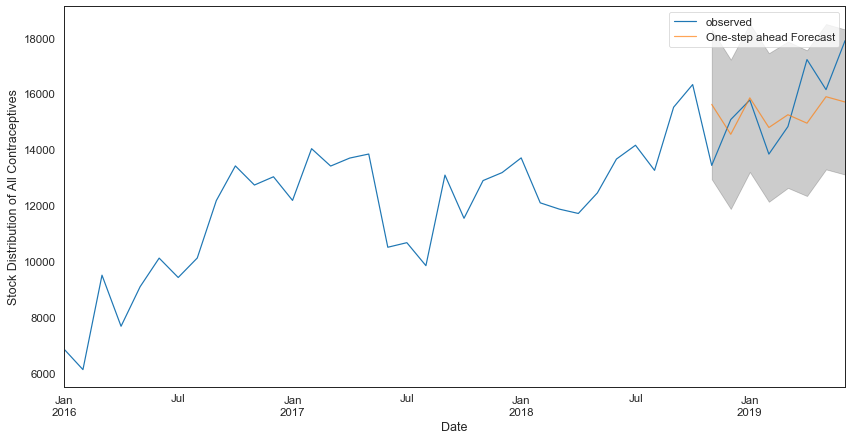

In [271]:
pred = results.get_prediction(start=pd.to_datetime('2018-11-30'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2016-01-31':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Stock Distribution of All Contraceptives')
plt.legend()
plt.show()

test_df['SARIMA2'] = pred.predicted_mean

In [180]:
print('RMSE:', round(RMSE(test_df['stock_distributed'], test_df['ARIMA']), 2) )
print('MAE:', round(MAE(test_df['stock_distributed'], test_df['ARIMA']), 2))
print('MAPE:', round(MAPE(test_df['stock_distributed'], test_df['ARIMA']), 2))
print('MASE:', round(MASE(train_df['stock_distributed'], test_df['stock_distributed'], test_df['ARIMA']), 2))

RMSE: 1425.73
MAE: 1113.19
MAPE: 7.14
MASE: 0.98


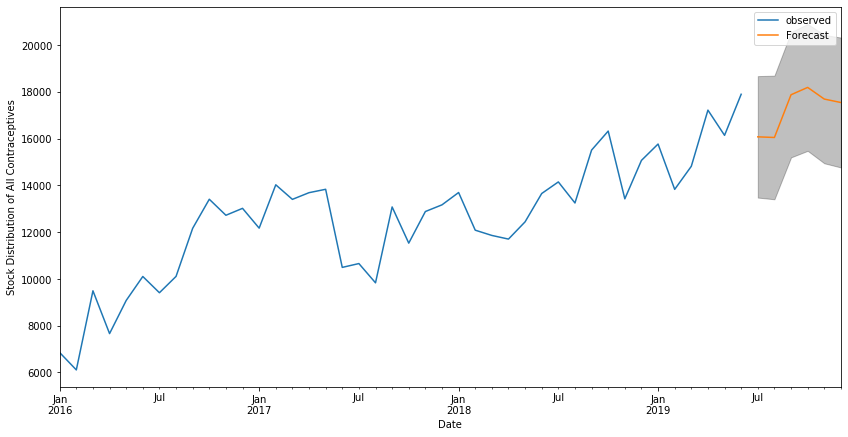

In [143]:
pred_uc = results.get_forecast(steps=6)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Stock Distribution of All Contraceptives')
plt.legend()
plt.show()

In [144]:
from fbprophet import Prophet


In [147]:
all_df = use_df.rename(columns={'calendar': 'ds', 'stock_distributed': 'y'})
all_model = Prophet(interval_width=0.95)
all_model.fit(all_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [160]:
all_forecast = all_model.make_future_dataframe(periods=6, freq='MS')
all_forecast = all_model.predict(all_forecast)

Text(0.5, 1, 'All Contraceptives')

<Figure size 1296x432 with 0 Axes>

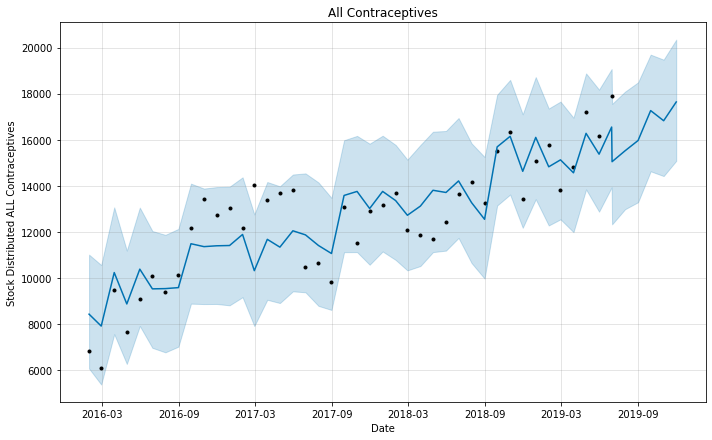

In [161]:
plt.figure(figsize=(18, 6))
all_model.plot(all_forecast, xlabel = 'Date', ylabel = 'Stock Distributed ALL Contraceptives')
plt.title('All Contraceptives')

In [162]:
all_forecast.set_index('ds', inplace = True, drop = False)

In [169]:
test_df = all_forecast[['yhat', 'ds']].merge(test_df, left_on = all_forecast['ds'], right_on = test_df['calendar'], how = 'inner')

In [181]:
print('RMSE:', round(RMSE(test_df['stock_distributed'], test_df['yhat']), 2) )
print('MAE:', round(MAE(test_df['stock_distributed'], test_df['yhat']), 2))
print('MAPE:', round(MAPE(test_df['stock_distributed'], test_df['yhat']), 2))
print('MASE:', round(MASE(train_df['stock_distributed'], test_df['stock_distributed'], test_df['yhat']), 2))

RMSE: 1027.62
MAE: 974.26
MAPE: 6.33
MASE: 0.86


In [188]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [184]:
# fix random seed for reproducibility
np.random.seed(7)

In [191]:
use_df.reset_index(drop = True)
stat, p = stats.normaltest(use_df.stock_distributed)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')


Statistics=1.603, p=0.449
Data looks Gaussian (fail to reject H0)


Kurtosis of normal distribution: 0.041848663055869206
Skewness of normal distribution: -0.3953645912097662


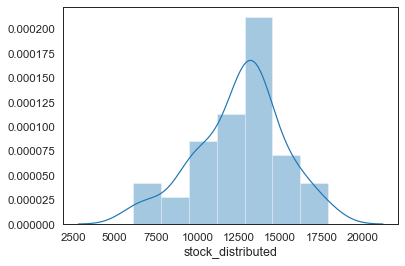

In [194]:
sns.distplot(use_df.stock_distributed);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(use_df.stock_distributed)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(use_df.stock_distributed)))

,count,mean,std,min,25%,50%,75%,max
stock_distributed,42.0000,12568.3095,2626.5617,6111.0000,10878.5000,13052.0000,13836.2500,17902.0000


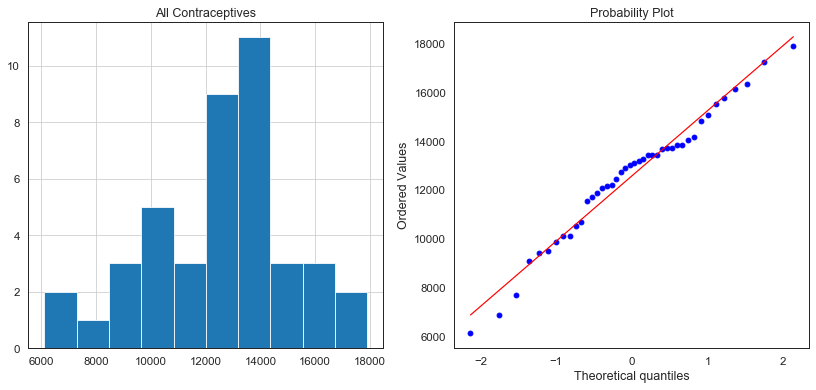

In [196]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
use_df.stock_distributed.hist(bins=10)
plt.title('All Contraceptives')
plt.subplot(1,2,2)
stats.probplot(use_df.stock_distributed, plot=plt);
df1.describe().T

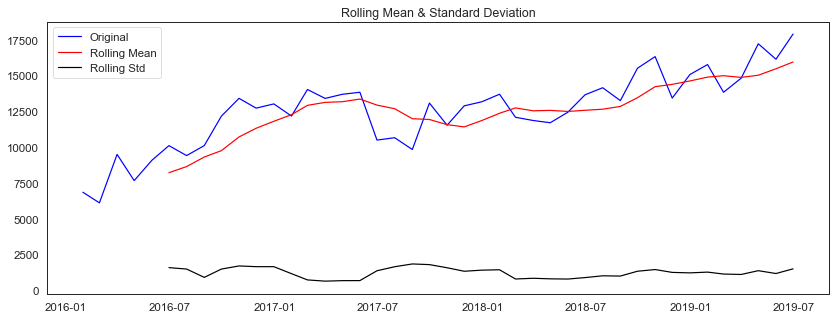

<Results of Dickey-Fuller Test>
Test Statistic                -2.0199
p-value                        0.2779
#Lags Used                     1.0000
Number of Observations Used   40.0000
Critical Value (1%)           -3.6056
Critical Value (5%)           -2.9371
Critical Value (10%)          -2.6070
dtype: float64


In [201]:
df2=use_df.copy()

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=6).mean()
    rolstd = timeseries.rolling(window=6).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(df2.stock_distributed.dropna())

In [261]:
dataset = use_df.stock_distributed.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 1
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [267]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_absolute_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=200, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

ValueError: Data cardinality is ambiguous:
  x sizes: 31
  y sizes: 1
Please provide data which shares the same first dimension.

In [268]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

ValueError: Found array with dim 3. Estimator expected <= 2.

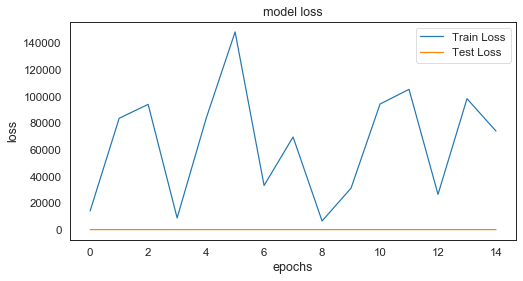

In [269]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

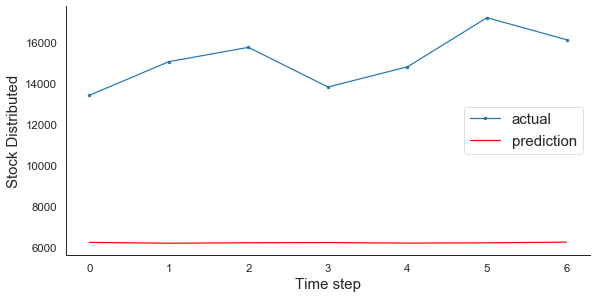

In [266]:
aa=[x for x in range(7)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0], marker='.', label="actual")
plt.plot(aa, test_predict[:,0], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Stock Distributed', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();